In [2]:
%env CUDA_VISIBLE_DEVICES = 3

env: CUDA_VISIBLE_DEVICES=3


In [3]:
%load_ext autoreload
%autoreload 2
import os
import sys; 
sys.path.extend(['/home/meet/FlowMatchingTests/conditional-flow-matching/'])

import matplotlib.pyplot as plt
import numpy as np
import torch

from tqdm import tqdm
from torchcfm.conditional_flow_matching import *
from physics_flow_matching.unet.mlp import MLP_Wrapper as MLP
from einops import rearrange
from physics_flow_matching.inference_scripts.uncond import infer, infer_rf_noise
from physics_flow_matching.multi_fidelity.synthetic.dataset import Syn_Data_FM_multi_to_multi
from physics_flow_matching.inference_scripts.cond import d_flow, d_flow_ssag, infer_grad, infer_gradfree, flow_daps
from physics_flow_matching.inference_scripts.utils import cost_func, cost_func_exp, ssag_get_norm_params, ssag_sample, sample_noise, grad_cost_func
from physics_flow_matching.multi_fidelity.synthetic.dists.base import get_distribution
from torch.distributions import Exponential

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
test_data1 = get_distribution('gaussian').sample(1000).to(device)
test_data2 = get_distribution('s_curve').sample(1000).to(device)

In [6]:
exp = "mlp"
iteration = 1500
ot_cfm_model = MLP(input_dim=3,
                   output_dim=2,
                   hidden_dims=[128, 128, 128, 128]
                )
state = torch.load(f"/home/meet/FlowMatchingTests/conditional-flow-matching/physics_flow_matching/multi_fidelity/exps/{exp}/exp_8/saved_state/checkpoint_{iteration}.pth")
ot_cfm_model.load_state_dict(state["model_state_dict"])
ot_cfm_model.to(device)
ot_cfm_model.eval();

/tmp/ipykernel_1914377/569647235.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(f"/home/meet/FlowMatchingTests/conditional-flow-matching/physics_flow

## Uncond Generation

In [7]:
total_samples = 1000
samples_per_batch = 100

In [8]:
# %%timeit
samples = infer(dims_of_img=(2,), total_samples=total_samples, samples_per_batch=samples_per_batch,
                use_odeint=True, cfm_model=ot_cfm_model, 
                t_start=0., t_end=1., scale=False, device=device, m=None, std=None,
                method="dopri5", use_heavy_noise=False, nu=3, y0_provided=True, y0=test_data1.to(device), all_traj=False) #, options={"step_size":1/time_steps}, t_steps=10

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 11.68it/s]


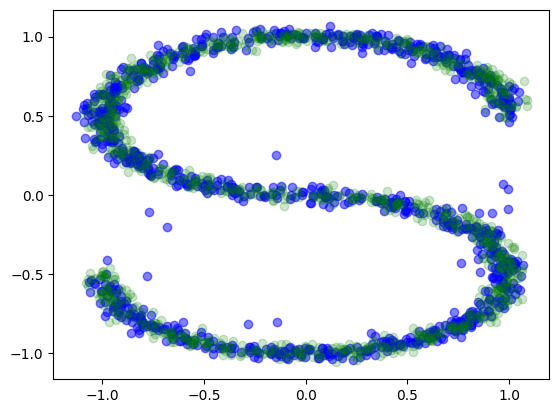

In [9]:
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, label="GEN", color="blue")
plt.scatter(test_data2[:, 0].detach().cpu(), test_data2[:, 1].detach().cpu(), alpha=0.2, label="GT", color="green")
# plt.hist((0.5*torch.randn(1000, 1) + 10).cpu(), bins=100, density=True, alpha=0.5, label="COND", color="red")
plt.show()

## Analyse Guidance methods

In [10]:
meas_func = lambda x, **kwargs: ((x[0] - x[1]).abs() * 5) #((x[0] - x[1]).abs() * 5)**0.5 

In [30]:
total_samples = 100
samples_per_batch = 1
num_of_steps = 20

In [31]:
initial_points  =  get_distribution('gaussian').sample(total_samples).to(device)#torch.randn(total_samples, 2).to(device)
initial_points_plot = initial_points.detach().cpu().numpy()
measurement_points = torch.zeros(total_samples).to(device)#Exponential(rate=2.).sample((total_samples,)).to(device) #0.6*torch.randn(total_samples).to(device).abs()#  torch.zeros(total_samples).to(device) # 

In [ ]:
samples_cond_grad = [flow_daps(fm=ExactOptimalTransportConditionalFlowMatcher(sigma=1e-3), cfm_model=ot_cfm_model,
                                samples_per_batch=1, total_samples=1,
                                dims_of_img=(2,), num_of_steps=num_of_steps, grad_cost_func=grad_cost_func, meas_func=meas_func,
                                conditioning=measurement[None], device=device,
                                beta=1e-2, eta=torch.linspace(1e-6, 1e-8, num_of_steps), r=torch.linspace(1e-2, 1e-2, num_of_steps), langevin_mc_steps=100,
                                sample_noise=sample_noise, use_heavy_noise=False, start_provided=True, start_point=initial_point)
                     for initial_point, measurement in zip(initial_points, measurement_points)]

  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:01<00:00, 10.65it/s, distance=0.572]


KeyboardInterrupt: 

In [24]:
# samples_cond_grad = [infer_grad(fm=FlowMatcher(sigma=1e-3), cfm_model=ot_cfm_model,
#                                 swag=False, samples_per_batch=1, total_samples=1,
#                                 dims_of_img=(2,), num_of_steps=200, grad_cost_func=grad_cost_func, meas_func= meas_func,
#                                 conditioning=measurement, conditioning_scale=10., device=device, refine=1, sample_noise=sample_noise,
#                                 use_heavy_noise=False, rf_start=False, start_provided=True, start_point=initial_point) #cost_func=cost_func_exp 
#                      for initial_point, measurement in zip(initial_points, measurement_points)]

In [33]:
samples_cond_guide = np.stack([s for s in samples_cond_grad], axis=0)

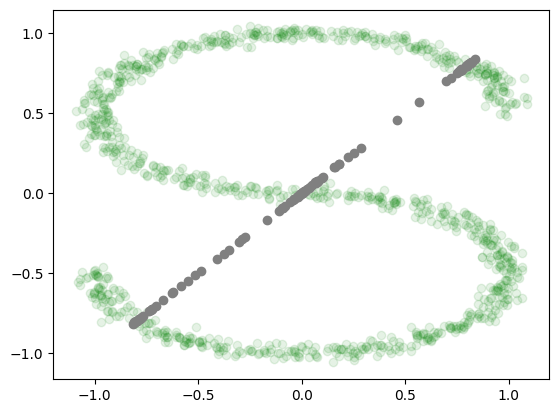

In [34]:
plt.scatter(test_data2[:, 0].cpu(), test_data2[:, 1].cpu(), alpha=0.1, label="GT", color="green")
# plt.scatter(measurement_points[:, 0].cpu(), measurement_points[:, 1].cpu(), alpha=0.2, label="COND", color="red")
plt.scatter(samples_cond_guide[:, 0], samples_cond_guide[:, 1], alpha=1, label="COND", color="grey")
plt.show()

## Analyse Gradient-Free Guidance Methods

In [106]:
total_samples = 1000
samples_per_batch = 1

In [107]:
initial_points  = test_data1[:1000].to(device)#torch.randn(total_samples, 2).to(device)
initial_points_plot = initial_points.detach().cpu().numpy()
measurement_points =Exponential(rate=2.).sample((total_samples,)).to(device) #torch.randn(total_samples).to(device).abs()

In [108]:
samples_cond_grad = [infer_gradfree(fm=FlowMatcher(sigma=1e-3), cfm_model=ot_cfm_model,swag=False,
                               samples_per_batch=1, total_samples=1,
                               dims_of_img=(2,), num_of_steps=100, grad_cost_func=grad_cost_func, meas_func= meas_func,
                               conditioning=measurement, conditioning_scale=10., device=device, refine=1, sample_noise=sample_noise,
                               use_heavy_noise=False, rf_start=False, start_provided=True, start_point=initial_point)  for initial_point, measurement in zip(initial_points, measurement_points)]

  0%|          | 0/99 [00:00<?, ?it/s]

100%|██████████| 99/99 [00:00<00:00, 1327.84it/s, distance=0.0169]


In [109]:
samples_cond_guide = np.stack([s for s in samples_cond_grad], axis=0)

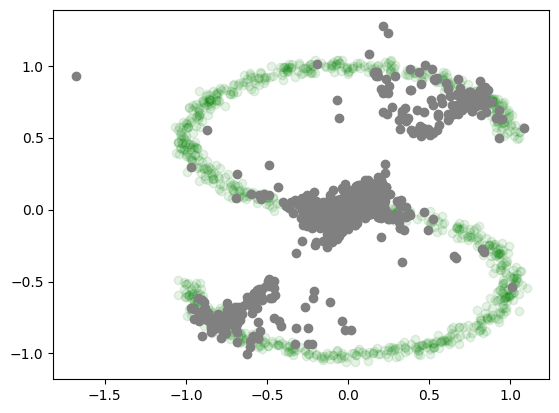

In [110]:
plt.scatter(test_data2[:, 0].cpu(), test_data2[:, 1].cpu(), alpha=0.1, label="GT", color="green")
# plt.scatter(measurement_points[:, 0].cpu(), measurement_points[:, 1].cpu(), alpha=0.2, label="COND", color="red")
plt.scatter(samples_cond_guide[:, 0], samples_cond_guide[:, 1], alpha=1, label="COND", color="grey")
plt.show()

## Analyze D-Flow

In [31]:
total_samples = 100

In [32]:
initial_points  =  get_distribution('circle').sample(total_samples).to(device)#torch.randn(total_samples, 2).to(device)
initial_points_plot = initial_points.detach().cpu().numpy()
measurement_points =  Exponential(rate=1.).sample((total_samples,)).to(device)  #torch.zeros(total_samples).to(device) #torch.randn(total_samples).to(device).abs() #0.8*(torch.randn(total_samples).to(device)).abs() # # Exponential(rate=2.).sample((total_samples,)).to(device) 

In [33]:
samples_cond = [d_flow(cost_func= cost_func, measurement_func= meas_func, measurement=measurement , flow_model=ot_cfm_model,
                      initial_point=initial_point, full_output=True) for initial_point, measurement in zip(initial_points, measurement_points)]

100%|██████████| 10/10 [00:00<00:00, 49.30it/s, distance=3.01e-11]


In [34]:
samples_cond_ = np.stack([s for s in samples_cond], axis=0)

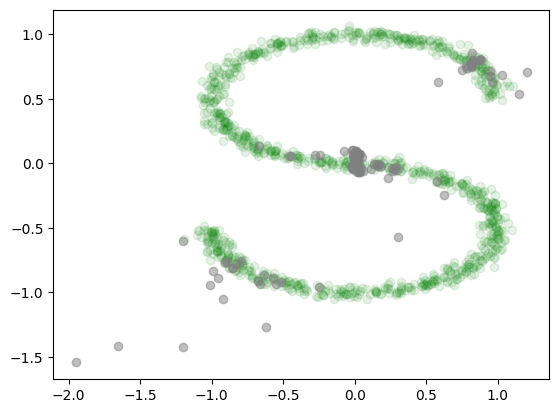

In [35]:
plt.scatter(test_data2[:, 0].cpu(), test_data2[:, 1].cpu(), alpha=0.1, label="GT", color="green")
# plt.scatter(measurement_points[:, 0].cpu(), measurement_points[:, 1].cpu(), alpha=0.2, label="COND", color="red")
plt.scatter(samples_cond_[:, -1, 0], samples_cond_[:, -1, 1], alpha=0.5, label="COND", color="grey")
plt.show()

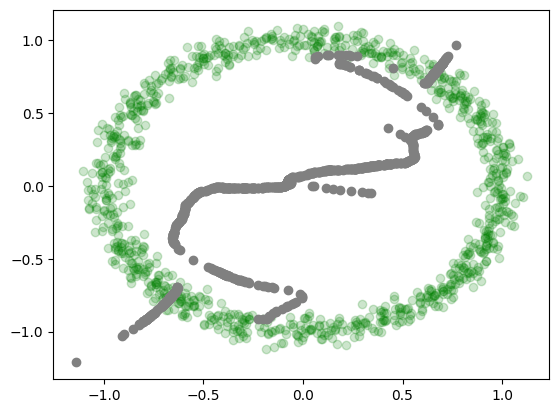

In [48]:
plt.scatter(initial_points_plot[:, 0], initial_points_plot[:, 1], alpha=0.2, label="GT", color="green")
plt.scatter(samples_cond_[:, 0, 0], samples_cond_[:, 0, 1], label="COND", color="grey")
plt.show()

## Check the prior samples

In [120]:
samples_prior = infer(dims_of_img=(2,), total_samples=total_samples, samples_per_batch=samples_per_batch,
                use_odeint=True, cfm_model=ot_cfm_model, 
                t_start=0., t_end=1., scale=False, device=device, m=None, std=None,
                method="dopri5", use_heavy_noise=False, nu=None, y0_provided=True, y0=torch.from_numpy(initial_points_plot).to(device), t_steps=10, all_traj=True) #, options={"step_size":1/time_steps}, t_steps=10

100%|██████████| 1000/1000 [00:16<00:00, 59.32it/s]


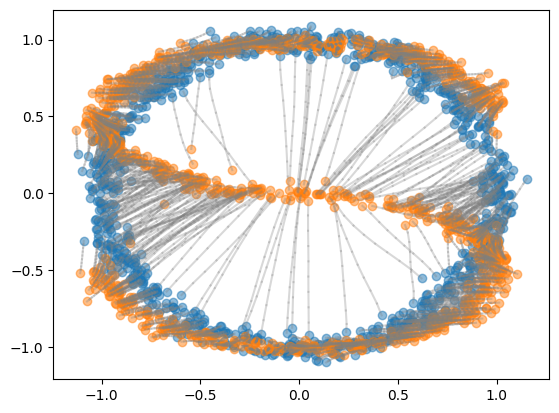

In [121]:
for i in range(total_samples):
    for j in range(samples_prior.shape[0]):
        plt.plot(samples_prior[j:j+2, i, 0], samples_prior[j:j+2, i, 1], c='gray', alpha=0.3)
    # plt.plot(samples_prior[:, i, 0], samples_prior[:, i, 1] , c='gray', alpha=0.3)

plt.scatter(samples_prior[0, :, 0], samples_prior[0, :, 1], alpha=0.5, label="GT")
plt.scatter(samples_prior[-1, :, 0], samples_prior[-1, :, 1], alpha=0.5, label="Gen")
plt.show()

## Analyze D-Flow SSAG

In [113]:
initial_points  = data1_test[:1000].to(device)#torch.randn(total_samples, 2).to(device)
initial_points_plot = initial_points.detach().cpu().numpy()
measurement_points = (torch.randn(total_samples, 2) @ torch.tensor([[0.1, 0.0], [0.0, 0.1]]) + torch.tensor([1.0, 1.0])).to(device)

In [114]:
# np.mean(samples_cond_[:, 0], axis=0), np.cov(samples_cond_[:, 0].T)

In [124]:
# l = [d_flow_ssag(cost_func= cost_func, measurement_func= lambda x: x, measurement=measurement_points[i].clone() , flow_model=ot_cfm_model, initial_point=initial_points[i].clone(),
      # max_iterations=200, start_collect_phase=100, cov_rank=20, optimizer=Adam, optimizer_kwargs={"lr" : 0.05}, collect_phase_optimizer_kwargs={"lr": 0.1}, momt_coll_freq=2) for i in range(4)]

l = [d_flow_ssag(cost_func= cost_func, measurement_func= lambda x: x, measurement=measurement_points[i].clone() , flow_model=ot_cfm_model, initial_point=initial_points[i].clone(),
      max_iterations=200, start_collect_phase=100, cov_rank=50, optimizer_kwargs={"lr" : 0.01, "momentum": 0.9}, collect_phase_optimizer_kwargs={"lr": 0.3, "momentum": 0.9}, momt_coll_freq=2) for i in range(5)] #lr:0.1

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:01<00:00, 109.12it/s, distance=4.1e-6]  


In [125]:
l

[(tensor([2.5444, 0.8450], device='cuda:0'),
  tensor([6.5231, 0.8334], device='cuda:0'),
  tensor([[ 0.0000,  0.0000],
          [-0.0866,  0.2629],
          [-0.1540,  0.5067],
          [-0.2598,  0.6863],
          [-0.4688,  0.7357],
          [-0.5385,  0.8259],
          [-0.5679,  0.8574],
          [-0.6042,  0.7824],
          [-0.4977,  0.7562],
          [-0.4599,  0.5991],
          [-0.3147,  0.5017],
          [-0.2090,  0.3538],
          [-0.1108,  0.2083],
          [ 0.0204,  0.1208],
          [ 0.0713,  0.0028],
          [ 0.1136, -0.0812],
          [ 0.1702, -0.1144],
          [ 0.1789, -0.1449],
          [ 0.1615, -0.1623],
          [ 0.1616, -0.1431],
          [ 0.1520, -0.1116],
          [ 0.1124, -0.0879],
          [ 0.0812, -0.0509],
          [ 0.0622, -0.0036],
          [ 0.0280,  0.0297],
          [-0.0043,  0.0582],
          [-0.0187,  0.0909],
          [-0.0366,  0.1092],
          [-0.0539,  0.1156],
          [-0.0536,  0.1245],
          

In [126]:
l2 = [ssag_get_norm_params(fm, sm, dev_mat, visualize=True, scale=0.25) for fm, sm, dev_mat, _ in l]

In [127]:
l2

[(array([2.5444453 , 0.84500444], dtype=float32),
  array([[ 0.02298003, -0.01585137],
         [-0.01585137,  0.05520044]], dtype=float32)),
 (array([2.7078967 , 0.19940735], dtype=float32),
  array([[ 0.01139027, -0.01200991],
         [-0.01200991,  0.06235522]], dtype=float32)),
 (array([2.29032   , 0.99478525], dtype=float32),
  array([[ 0.02337282, -0.01597683],
         [-0.01597683,  0.04968492]], dtype=float32)),
 (array([1.9779048, 1.366425 ], dtype=float32),
  array([[ 0.02808208, -0.0164186 ],
         [-0.0164186 ,  0.04760042]], dtype=float32)),
 (array([2.1727254, 1.1559888], dtype=float32),
  array([[ 0.02039104, -0.01243864],
         [-0.01243864,  0.03444633]], dtype=float32))]

In [128]:
samples_prior_ssag = [np.random.multivariate_normal(m, var, size=1000) for m, var in l2]

### Adam

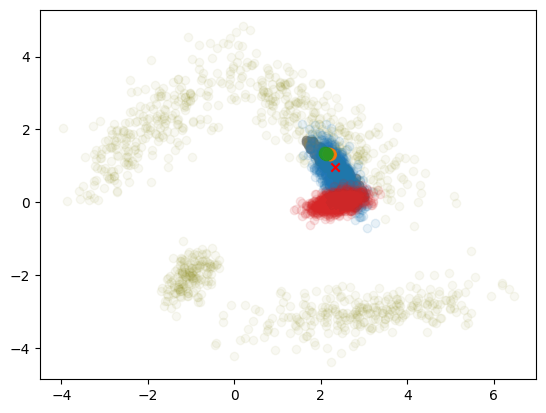

In [280]:
plt.scatter(samples_cond_[:, 0, 0], samples_cond_[:, 0, 1], alpha=0.7, label="COND", color="grey")
plt.scatter(initial_points_plot[:, 0], initial_points_plot[:, 1], alpha=0.05, label="GT", color="olive")
for i in range(4):
    plt.scatter(samples_prior_ssag[i][:, 0], samples_prior_ssag[i][:, 1], alpha=0.1)
plt.scatter(samples_cond_[:, 0, 0].mean(axis=0), samples_cond_[:, 0, 1].mean(axis=0), alpha=1, label="COND", color="red", marker="x")
plt.show()

### SGD

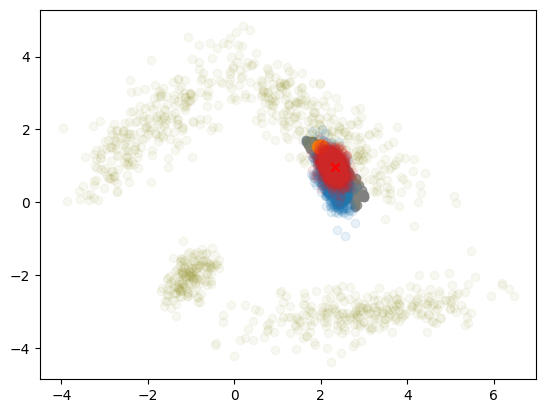

In [360]:
plt.scatter(samples_cond_[:, 0, 0], samples_cond_[:, 0, 1], alpha=0.7, label="COND", color="grey")
plt.scatter(initial_points_plot[:, 0], initial_points_plot[:, 1], alpha=0.05, label="GT", color="olive")
for i in range(4):
    plt.scatter(samples_prior_ssag[i][:, 0], samples_prior_ssag[i][:, 1], alpha=0.1)
plt.scatter(samples_cond_[:, 0, 0].mean(axis=0), samples_cond_[:, 0, 1].mean(axis=0), alpha=1, label="COND", color="red", marker="x")
plt.show()

### Forward pass

In [129]:
y0 = [torch.stack([ssag_sample(fm, sm, dev_mat, (2), device=device, scale=0.1) for _ in range(1000)], dim=0) for fm, sm, dev_mat, _ in l]

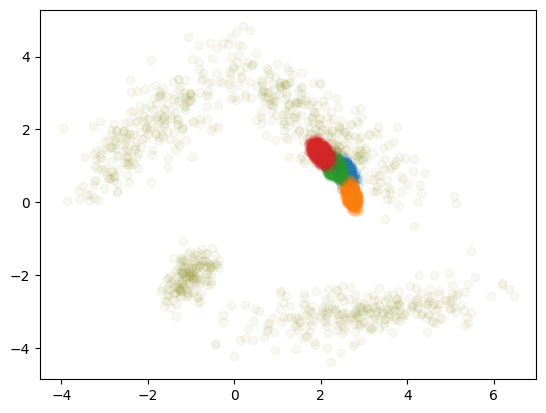

In [130]:
# plt.scatter(samples_cond_[:, 0, 0], samples_cond_[:, 0, 1], alpha=0.7, label="COND", color="grey")
plt.scatter(initial_points_plot[:, 0], initial_points_plot[:, 1], alpha=0.05, label="GT", color="olive")
for i in range(4):
    plt.scatter(y0[i][:, 0].detach().cpu(), y0[i][:, 1].detach().cpu(), alpha=0.1)
# plt.scatter(samples_cond_[:, 0, 0].mean(axis=0), samples_cond_[:, 0, 1].mean(axis=0), alpha=1, label="COND", color="red", marker="x")
plt.show()

In [131]:
# %%timeit
samples_from_ssag = [infer(dims_of_img=(2,), total_samples=1000, samples_per_batch=100,
                use_odeint=True, cfm_model=ot_cfm_model, 
                t_start=0., t_end=1., scale=False, device=device, m=None, std=None,
                method="dopri5", use_heavy_noise=False, nu=3, y0_provided=True, y0=y0[i].clone(), all_traj=True, t_steps=10) for i in range(len(y0))]#,

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 53.21it/s]


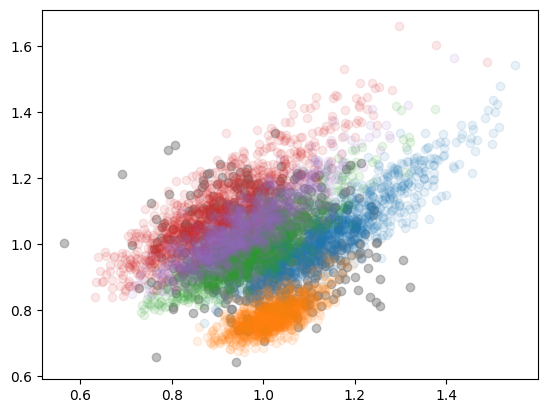

In [132]:
plt.scatter(measurement_points[:, 0].cpu(), measurement_points[:, 1].cpu(), alpha=0.5, label="COND", color="grey")
# plt.scatter(samples[:, 0], samples[:, 1], alpha=0.01, label="GEN", color="olive")
for i in range(len(y0)):
    plt.scatter(samples_from_ssag[i][-1, :, 0], samples_from_ssag[i][-1, :, 1], alpha=.1, label="SSAG")
plt.show()

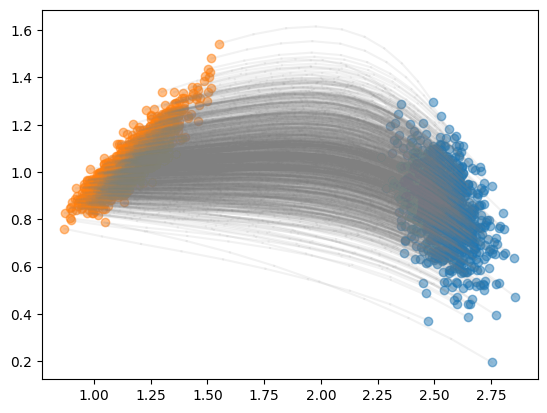

In [133]:
for i in range(1000):
    for j in range(samples_from_ssag[0].shape[0]):
        plt.plot(samples_from_ssag[0][j:j+2, i, 0], samples_from_ssag[0][j:j+2, i, 1], c='gray', alpha=0.1)
    # plt.plot(samples_prior[:, i, 0], samples_prior[:, i, 1] , c='gray', alpha=0.3)

plt.scatter(samples_from_ssag[0][0, :, 0], samples_from_ssag[0][0, :, 1], alpha=0.5, label="GT")
plt.scatter(samples_from_ssag[0][-1, :, 0], samples_from_ssag[0][-1, :, 1], alpha=0.5, label="Gen")
# plt.scatter(samples[:, 0], samples[:, 1], alpha=0.01, label="GEN", color="olive")
plt.show()

### GT

In [201]:
fitting_gauss_on_samples_cond_ = np.random.multivariate_normal(np.mean(samples_cond_[:, 0], axis=0), np.cov(samples_cond_[:, 0].T), size=1000)

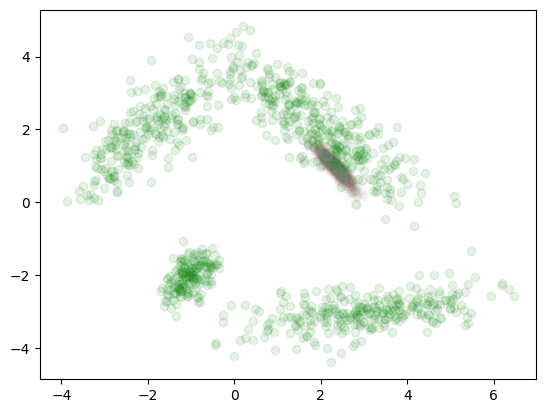

In [202]:
plt.scatter(fitting_gauss_on_samples_cond_[:, 0], fitting_gauss_on_samples_cond_[:, 1], alpha=0.01, label="COND", color="pink")
plt.scatter(samples_cond_[:, 0, 0], samples_cond_[:, 0, 1], alpha=0.01, label="COND", color="grey")
plt.scatter(initial_points_plot[:, 0], initial_points_plot[:, 1], alpha=0.1, label="GT", color="green")